Disclaimer: I used images from Stanford Cars Dataset to help train the classification model since otherwise, the dataset would be way too inbalanced to train with. 

# **Import Libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import time
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import shutil
import seaborn as sns
import xgboost
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.metrics import mean_absolute_error

# **Dataframes**

In [2]:
train_df = pd.read_csv('../input/fast-furious-and-insured/Fast_Furious_Insured/train.csv')
test_df = pd.read_csv('../input/fast-furious-and-insured/Fast_Furious_Insured/test.csv')
train_df, valid_df = train_test_split(train_df, train_size=0.95, random_state=0)

In [3]:
train_df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
152,img_7765048.jpg,DA,29500.0,737.5,2027-01-17,7453.0,1,5408.0
1298,img_7766630.jpg,A,49500.0,1237.5,2022-06-30,12453.0,1,8941.0
1150,img_4518055.jpg,RE,49600.0,1240.0,2028-12-26,12478.0,1,4487.0
943,img_4515550.jpg,BC,44000.0,1100.0,2026-08-23,11078.0,1,8416.0
1084,img_7765851.jpg,AA,23500.0,587.5,2024-06-25,5953.0,1,3208.0


In [4]:
train_df = train_df.rename(columns={'Image_path': 'file_path', 'Condition': 'labels'})

In [5]:
valid_df = valid_df.rename(columns={'Image_path': 'file_path', 'Condition': 'labels'})
test_df = test_df.rename(columns={'Image_path': 'file_path', 'Condition': 'labels'})

In [6]:
train_path = '../input/fast-furious-and-insured/Fast_Furious_Insured/trainImages/'
test_path = '../input/fast-furious-and-insured/Fast_Furious_Insured/testImages/'

In [7]:
train_df.file_path = train_path + train_df.file_path

In [8]:
train_df.head()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,labels,Amount
152,../input/fast-furious-and-insured/Fast_Furious...,DA,29500.0,737.5,2027-01-17,7453.0,1,5408.0
1298,../input/fast-furious-and-insured/Fast_Furious...,A,49500.0,1237.5,2022-06-30,12453.0,1,8941.0
1150,../input/fast-furious-and-insured/Fast_Furious...,RE,49600.0,1240.0,2028-12-26,12478.0,1,4487.0
943,../input/fast-furious-and-insured/Fast_Furious...,BC,44000.0,1100.0,2026-08-23,11078.0,1,8416.0
1084,../input/fast-furious-and-insured/Fast_Furious...,AA,23500.0,587.5,2024-06-25,5953.0,1,3208.0


In [9]:
valid_df.file_path = train_path + valid_df.file_path
test_df.file_path = test_path + test_df.file_path

# **Balancing Classes in Train and Valid Dataframes**

In [10]:
train_df.labels.value_counts()

1    1237
0      92
Name: labels, dtype: int64

In [11]:
valid_df.labels.value_counts()

1    63
0     7
Name: labels, dtype: int64

Dataset is extremely unbalanced. We will add images of cars from the Stanford Cars Dataset to combat this.  

In [12]:
train_class_diff = 1237-92
valid_class_diff = 63-7

In [13]:
labels = []
file_path = []
for file in glob.glob('../input/stanford-cars-dataset/cars_train/cars_train/*.jpg'):
    labels.append(0)
    file_path.append(file)
print ('file_path: ', len(file_path), '   labels: ', len(labels))

file_path:  8144    labels:  8144


In [14]:
Fseries = pd.Series(file_path, name='file_path')
Lseries = pd.Series(labels, name='labels')
stanford_df = pd.concat([Fseries,Lseries], axis=1)
stanford_df = pd.DataFrame(np.array(stanford_df).reshape(8144,2), columns = ['file_path', 'labels'])
print(stanford_df['labels'].value_counts())

0    8144
Name: labels, dtype: int64


In [15]:
balance_images = stanford_df.sample(train_class_diff + valid_class_diff, random_state = 0)
balance_images.head()

,file_path,labels
5863,../input/stanford-cars-dataset/cars_train/cars...,0
6459,../input/stanford-cars-dataset/cars_train/cars...,0
1817,../input/stanford-cars-dataset/cars_train/cars...,0
6716,../input/stanford-cars-dataset/cars_train/cars...,0
39,../input/stanford-cars-dataset/cars_train/cars...,0


In [16]:
train_balance = balance_images[:train_class_diff]
valid_balance = balance_images[-valid_class_diff:]
print(train_balance.size, valid_balance.size)

2290 112


In [17]:
balanced_class_train_df = pd.concat([train_df, train_balance], axis=0)

In [18]:
balanced_class_train_df = balanced_class_train_df.reset_index(drop=True)

In [19]:
balanced_class_train_df.head()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,labels,Amount
0,../input/fast-furious-and-insured/Fast_Furious...,DA,29500.0,737.5,2027-01-17,7453.0,1,5408.0
1,../input/fast-furious-and-insured/Fast_Furious...,A,49500.0,1237.5,2022-06-30,12453.0,1,8941.0
2,../input/fast-furious-and-insured/Fast_Furious...,RE,49600.0,1240.0,2028-12-26,12478.0,1,4487.0
3,../input/fast-furious-and-insured/Fast_Furious...,BC,44000.0,1100.0,2026-08-23,11078.0,1,8416.0
4,../input/fast-furious-and-insured/Fast_Furious...,AA,23500.0,587.5,2024-06-25,5953.0,1,3208.0


In [20]:
balanced_class_train_df.tail()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,labels,Amount
2469,../input/stanford-cars-dataset/cars_train/cars...,NaN,NaN,NaN,NaN,NaN,0,NaN
2470,../input/stanford-cars-dataset/cars_train/cars...,NaN,NaN,NaN,NaN,NaN,0,NaN
2471,../input/stanford-cars-dataset/cars_train/cars...,NaN,NaN,NaN,NaN,NaN,0,NaN
2472,../input/stanford-cars-dataset/cars_train/cars...,NaN,NaN,NaN,NaN,NaN,0,NaN
2473,../input/stanford-cars-dataset/cars_train/cars...,NaN,NaN,NaN,NaN,NaN,0,NaN


In [21]:
balanced_class_valid_df = pd.concat([valid_df, valid_balance], axis=0)

In [22]:
balanced_class_valid_df = balanced_class_valid_df.reset_index(drop=True)

In [23]:
balanced_class_valid_df.head()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,labels,Amount
0,../input/fast-furious-and-insured/Fast_Furious...,DA,41000.0,1025.0,2027-07-10,10328.0,1,8707.0
1,../input/fast-furious-and-insured/Fast_Furious...,A,26000.0,650.0,2028-11-17,6578.0,1,6598.0
2,../input/fast-furious-and-insured/Fast_Furious...,B,30000.0,750.0,2026-07-09,7578.0,1,2596.0
3,../input/fast-furious-and-insured/Fast_Furious...,A,40400.0,1010.0,2024-07-07,10178.0,1,4376.0
4,../input/fast-furious-and-insured/Fast_Furious...,BC,32500.0,812.5,2026-02-18,8203.0,1,6857.0


In [24]:
class_dict = {0: 'Undamaged', 1: 'Damaged'}

In [25]:
balanced_class_train_df.labels = balanced_class_train_df.labels.map(class_dict)

In [26]:
balanced_class_train_df.head()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,labels,Amount
0,../input/fast-furious-and-insured/Fast_Furious...,DA,29500.0,737.5,2027-01-17,7453.0,Damaged,5408.0
1,../input/fast-furious-and-insured/Fast_Furious...,A,49500.0,1237.5,2022-06-30,12453.0,Damaged,8941.0
2,../input/fast-furious-and-insured/Fast_Furious...,RE,49600.0,1240.0,2028-12-26,12478.0,Damaged,4487.0
3,../input/fast-furious-and-insured/Fast_Furious...,BC,44000.0,1100.0,2026-08-23,11078.0,Damaged,8416.0
4,../input/fast-furious-and-insured/Fast_Furious...,AA,23500.0,587.5,2024-06-25,5953.0,Damaged,3208.0


In [27]:
balanced_class_valid_df.labels = balanced_class_valid_df.labels.map(class_dict)
balanced_class_valid_df.head()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,labels,Amount
0,../input/fast-furious-and-insured/Fast_Furious...,DA,41000.0,1025.0,2027-07-10,10328.0,Damaged,8707.0
1,../input/fast-furious-and-insured/Fast_Furious...,A,26000.0,650.0,2028-11-17,6578.0,Damaged,6598.0
2,../input/fast-furious-and-insured/Fast_Furious...,B,30000.0,750.0,2026-07-09,7578.0,Damaged,2596.0
3,../input/fast-furious-and-insured/Fast_Furious...,A,40400.0,1010.0,2024-07-07,10178.0,Damaged,4376.0
4,../input/fast-furious-and-insured/Fast_Furious...,BC,32500.0,812.5,2026-02-18,8203.0,Damaged,6857.0


In [28]:
print(balanced_class_train_df.labels.value_counts(),
      balanced_class_valid_df.labels.value_counts())

Damaged      1237
Undamaged    1237
Name: labels, dtype: int64 Undamaged    63
Damaged      63
Name: labels, dtype: int64


# **Visualize Images**

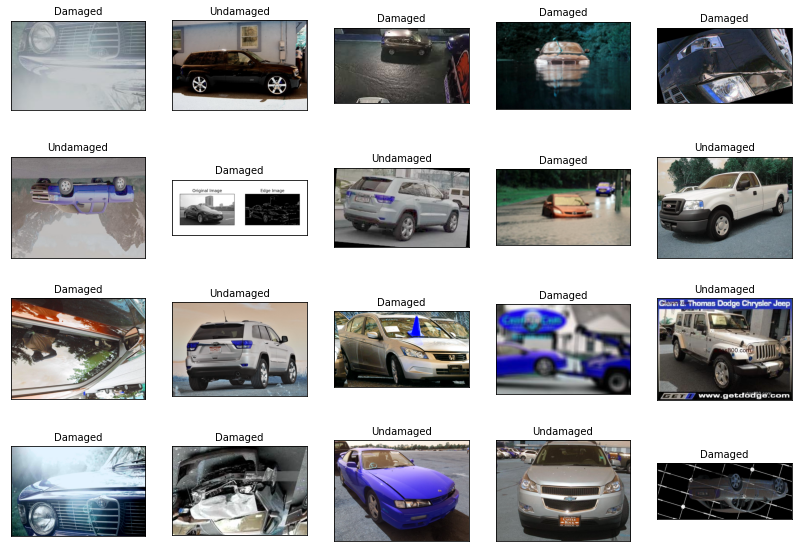

In [29]:
plt.figure(figsize = (14,10))
for i in range(20):
    random = np.random.randint(1,len(balanced_class_train_df))
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.imread(balanced_class_train_df.loc[random,"file_path"]))
    plt.title(balanced_class_train_df.loc[random, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# **Image Data Generator**

In [30]:
target_size=(299,299)
batch_size=64

In [31]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input, horizontal_flip=True, zoom_range=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_gen = train_datagen.flow_from_dataframe(balanced_class_train_df, x_col='file_path', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='binary')
valid_gen = test_datagen.flow_from_dataframe(balanced_class_valid_df, x_col='file_path', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='binary')

Found 2474 validated image filenames belonging to 2 classes.
Found 126 validated image filenames belonging to 2 classes.


# **Classification Model**

In [32]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape = (299,299,3))

219062272/219055592 [==============================] - 1s 0us/step


In [33]:
classification_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
lr=0.001
classification_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

# **Callbacks for Classification Model**

In [35]:
patience = 1
stop_patience = 3
factor = 0.5

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

# **Classification Model Training**

In [36]:
epochs = 30
history = classification_model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/30
39/39 [==============================] - 121s 3s/step - loss: 0.3130 - accuracy: 0.8565 - val_loss: 27780.7305 - val_accuracy: 0.5000
Epoch 2/30
39/39 [==============================] - 81s 2s/step - loss: 0.1280 - accuracy: 0.9604 - val_loss: 449.3858 - val_accuracy: 0.4921
Epoch 3/30
39/39 [==============================] - 81s 2s/step - loss: 0.0706 - accuracy: 0.9778 - val_loss: 15.2317 - val_accuracy: 0.5873
Epoch 4/30
39/39 [==============================] - 81s 2s/step - loss: 0.0817 - accuracy: 0.9752 - val_loss: 0.8077 - val_accuracy: 0.7937
Epoch 5/30
39/39 [==============================] - 81s 2s/step - loss: 0.0529 - accuracy: 0.9831 - val_loss: 0.4496 - val_accuracy: 0.8810
Epoch 6/30
39/39 [==============================] - 81s 2s/step - loss: 0.0437 - accuracy: 0.9832 - val_loss: 0.2680 - val_accuracy: 0.9206
Epoch 7/30
39/39 [==============================] - 80s 2s/step - loss: 0.0544 - accuracy: 0.9770 - val_loss: 0.7819 - val_accuracy: 0.8175

Epoch 00007

# **Model Training Graphs**

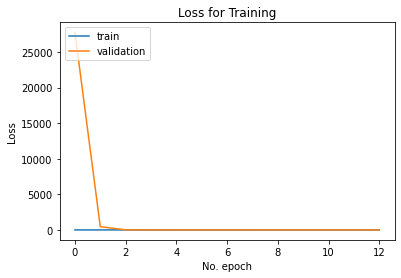

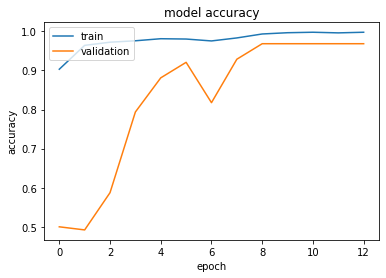

In [37]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Best Classification Model Predictions on Valid Set**

In [38]:
best_class_model = classification_model
best_class_model.load_weights('./classify_model.h5')
best_class_model.evaluate(valid_gen)

2/2 [==============================] - 1s 664ms/step - loss: 0.1309 - accuracy: 0.9683


[0.13089627027511597, 0.9682539701461792]

Pretty decent accuracy. 

# **XG Boost Model**

Dataframe Preprocessing

In [39]:
train_df.head()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,labels,Amount
152,../input/fast-furious-and-insured/Fast_Furious...,DA,29500.0,737.5,2027-01-17,7453.0,1,5408.0
1298,../input/fast-furious-and-insured/Fast_Furious...,A,49500.0,1237.5,2022-06-30,12453.0,1,8941.0
1150,../input/fast-furious-and-insured/Fast_Furious...,RE,49600.0,1240.0,2028-12-26,12478.0,1,4487.0
943,../input/fast-furious-and-insured/Fast_Furious...,BC,44000.0,1100.0,2026-08-23,11078.0,1,8416.0
1084,../input/fast-furious-and-insured/Fast_Furious...,AA,23500.0,587.5,2024-06-25,5953.0,1,3208.0


Need to encode labels since we cant have strings. I took this part from [this notebook.](https://www.kaggle.com/sohommajumder21/resnet50v2-and-randomforestregresion)

In [40]:
train_df['Insurance_company'] = LabelEncoder().fit_transform(train_df['Insurance_company'])
test_df['Insurance_company'] = LabelEncoder().fit_transform(test_df['Insurance_company'])

In [41]:
train_df.head()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,labels,Amount
152,../input/fast-furious-and-insured/Fast_Furious...,8,29500.0,737.5,2027-01-17,7453.0,1,5408.0
1298,../input/fast-furious-and-insured/Fast_Furious...,0,49500.0,1237.5,2022-06-30,12453.0,1,8941.0
1150,../input/fast-furious-and-insured/Fast_Furious...,10,49600.0,1240.0,2028-12-26,12478.0,1,4487.0
943,../input/fast-furious-and-insured/Fast_Furious...,5,44000.0,1100.0,2026-08-23,11078.0,1,8416.0
1084,../input/fast-furious-and-insured/Fast_Furious...,1,23500.0,587.5,2024-06-25,5953.0,1,3208.0


In [42]:
train_df.Expiry_date = train_df.Expiry_date.apply(pd.to_datetime)
train_df['month'] = train_df.Expiry_date.apply(lambda x: x.month)
train_df['day'] = train_df.Expiry_date.apply(lambda x: x.day)
train_df['year'] = train_df.Expiry_date.apply(lambda x: x.year)
train_df.drop(['Expiry_date'], 1, inplace = True)

test_df.Expiry_date = test_df.Expiry_date.apply(pd.to_datetime)
test_df['month'] = test_df.Expiry_date.apply(lambda x: x.month)
test_df['day'] = test_df.Expiry_date.apply(lambda x: x.day)
test_df['year'] = test_df.Expiry_date.apply(lambda x: x.year)
test_df.drop(['Expiry_date'], 1, inplace = True)

In [43]:
train_df.head()

,file_path,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,labels,Amount,month,day,year
152,../input/fast-furious-and-insured/Fast_Furious...,8,29500.0,737.5,7453.0,1,5408.0,1,17,2027
1298,../input/fast-furious-and-insured/Fast_Furious...,0,49500.0,1237.5,12453.0,1,8941.0,6,30,2022
1150,../input/fast-furious-and-insured/Fast_Furious...,10,49600.0,1240.0,12478.0,1,4487.0,12,26,2028
943,../input/fast-furious-and-insured/Fast_Furious...,5,44000.0,1100.0,11078.0,1,8416.0,8,23,2026
1084,../input/fast-furious-and-insured/Fast_Furious...,1,23500.0,587.5,5953.0,1,3208.0,6,25,2024


Finding important features

In [44]:
features = train_df[['Cost_of_vehicle', 'Insurance_company', 'Min_coverage', 'Max_coverage', 'month', 'day', 'year']]

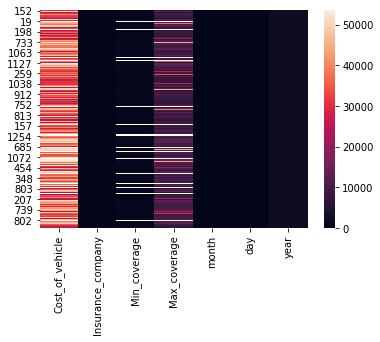

In [45]:
ax = sns.heatmap(features)

In [46]:
X = train_df[['Cost_of_vehicle', 'Max_coverage', 'Min_coverage']]
y = train_df['Amount']

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, random_state=0)

# **Training XGBoost Model**

In [48]:
regression_model = XGBRegressor(n_estimators=1000, learning_rate=0.001)
regression_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
predictions = regression_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Mean Absolute Error: 3790.7576523407624


First time using machine learning in a project, so bad results as expected :)